### questions from TJC
 - can we get estimates/error bars from wihtin individuals when it comes to dating admixture
 - can we get individual admixture ages per country (maybe a boxplot).
 - test for selection consider using the same ones from the previous paper and/or iHS.

# Ancestry *S.haematobium* vs. *S. bovis* across Africa (SCAN)

Neal Platt 2021

# Prep envrinoment and data for analyses

use the `scan_selection` conda environment

In [1]:
import os
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import statsmodels.stats.multitest as smm
import scipy.stats as stats
from pathlib import Path
from matplotlib.colors import ListedColormap
# from itertools import groupby
# import seaborn as sns
# import pickle
# #from collections import Counter
# from IPython.display import Image 
# import glob
# #import pybedtools
# import gffutils
# from scipy.signal import medfilt
from collections import defaultdict
#import vcf
#import loter.locanc.local_ancestry as lc

In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir=f"{proj_dir}/results"
os.chdir(results_dir)

## Get sample info

In [3]:
sample_info_df = pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir))

In [4]:
sample_info_df

,admera_id,barcode_label_ID,library_id,sample_name,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,19047FL-14-02-03,MCF03050E0612,na,sha_angola_cota_57,SRR11907442,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
1,19047FL-14-02-04,MCF03050E0613,na,sha_angola_cota_58,SRR11907441,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
2,19047FL-14-02-05,MCF03050E0614,na,sha_angola_cota_59,SRR11907440,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
3,19047FL-14-02-06,MCF03050E0615,na,sha_angola_icau_60,SRR11907439,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
4,19047FL-14-02-07,MCF03050E0615,na,sha_angola_icau_61,SRR11907438,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,na,na,na,sh_egypt_SRR433862,SRR433862,s_haematobium,egypt,na,na,haematobium,Rey_2019,genome,NaN,NaN
445,na,na,na,sh_gambia_SRR13579872,SRR13579872,s_haematobium,gambia,na,na,haematobium,Rey_2019,genome,NaN,NaN
446,na,na,na,sh_ivorycoast_SRR13579866,SRR13579866,s_haematobium,ivorycoast,na,na,haematobium,Rey_2019,genome,NaN,NaN
447,na,na,na,sh_madagascar_SRR13579871,SRR13579871,s_haematobium,madagascar,na,na,haematobium,Rey_2019,genome,NaN,NaN


## Read in data and get allele counts

In [5]:
#read in the vcf file
filtered_callset=allel.read_vcf(f'{results_dir}/post_phase_filtering/autosomes_unrelated.vcf')

In [6]:
#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [5]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

In [11]:
pca_df.loc[ (pca_df["kmeans_label"] == "sh_nw") & 
            (pca_df["project"] == "scan_africa")]

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
29,sbo_cdivoire_raviart_108,0.021400,-0.070582,-0.045198,0.206487,0.004450,0.012315,0.028276,-0.103222,-0.100459,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
30,sbo_cdivoire_raviart_109,0.020538,-0.076418,-0.046554,0.226617,-0.003926,-0.014860,-0.011537,-0.087275,-0.110759,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
31,sbo_niger_libore_154,0.025617,-0.079330,-0.013864,-0.055163,-0.001331,-0.003984,0.000089,-0.016355,0.055014,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
32,sbo_niger_libore_155,0.021715,-0.077734,-0.013288,-0.061101,0.008696,-0.056704,0.051375,-0.009732,0.050136,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
33,sbo_niger_libore_160,0.021868,-0.075221,-0.018740,-0.071181,-0.001439,-0.055054,0.051839,-0.075687,0.004744,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,ssp_niger_libore_166,0.022455,-0.078463,-0.021334,-0.066131,0.005504,-0.046551,0.052623,-0.059921,0.043647,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


### Species

In [8]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    
    #find indecies for each sample from that species
    names = pca_df.loc[pca_df["pca_species"] ==  sp, "sample_name"]
    sp_idxs[sp]=np.in1d(samples, names).nonzero()[0]

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.42s/it]


In [9]:
#add outgroups
s_guineensis   = "guineensis_saotome_ERR119612"
s_intercalatum = "intercalatum_drcongo_ERR119613"
s_margrebowiei = "margrebowiei_zambia_ERR310940"
s_matthei      = "matthei_zambia_ERR103051"

outgroups=[s_guineensis, s_intercalatum, s_margrebowiei, s_matthei]


In [10]:
for sp in tqdm(outgroups):
    sp_idxs[sp] = [list(samples).index(sp)]
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  2.00s/it]


### Kmeans group

In [11]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    
    #find indecies for each sample per k population
    ks = pca_df.loc[pca_df["kmeans_label"] ==  k, "sample_name"]
    k_pop_idxs[k]=np.in1d(samples, ks).nonzero()[0]
    
    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:26<00:00,  3.77s/it]


In [12]:
major_acs={"sh_nw":          k_pop_acs["sh_nw"],
           "sh_se":          k_pop_acs["sh_se"],
           "sb":             k_pop_acs["sb"] ,
           "sh":             sp_acs["s_haematobium"],
           "s_guineensis":   sp_acs["guineensis_saotome_ERR119612"],
           "s_intercalatum": sp_acs["intercalatum_drcongo_ERR119613"],
           "s_margrebowiei": sp_acs["margrebowiei_zambia_ERR310940"],
           "s_matthei":      sp_acs["matthei_zambia_ERR103051"]  }

# Selscan

In [73]:
Path("{}/selscan".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/selscan".format(results_dir))

In [ ]:
!ln -s ../post_phase_filtering/autosomes_unrelated.vcf

In [39]:
#samples with no lat/lon info cause major problems will need to exclude downstream
sh_nw_samples = pca_df.loc[pca_df["kmeans_label"] == "sh_nw", "sample_name" ].values
sh_se_samples = pca_df.loc[pca_df["kmeans_label"] == "sh_se", "sample_name" ].values
sb_samples    = pca_df.loc[pca_df["kmeans_label"] == "sb"   , "sample_name" ].values

np.savetxt("nw.list", sh_nw_samples, delimiter=',', fmt="%s")
np.savetxt("se.list", sh_se_samples, delimiter=',', fmt="%s")
np.savetxt("sb.list", sb_samples, delimiter=',', fmt="%s")

In [ ]:
%%bash 

vcftools \
    --vcf autosomes_unrelated.vcf \
    --keep nw.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >nw.vcf

In [ ]:
%%bash 

vcftools \
    --vcf autosomes_unrelated.vcf \
    --keep se.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >se.vcf

In [ ]:
%%bash 

vcftools \
    --vcf autosomes_unrelated.vcf \
    --keep sb.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sb.vcf

In [ ]:
cat nw.list se.list >sh.list

vcftools \
    --vcf autosomes_unrelated.vcf \
    --keep sh.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sh.vcf

In [ ]:
#create a map file
#< chr # > <id > < genetic position > < physical position >

 cut -f1-3 autosomes_unrelated.vcf | grep -v "#" | awk '{print $1"\t"$3"\t"$2/287000"\t"$2}' >selscan.map

In [ ]:
for CHROM in "NC_067195.1" "NC_067196.1" "NC_067197.1" "NC_067198.1" "NC_067199.1" "NC_067200.1" "NC_067201.1" "NC_067202.1"; do
    for POP in "nw" "sh" "se" "sb"; do
        conda run -n scan_selection --cwd . --live-stream vcftools --vcf ${POP}.vcf --chr ${CHROM} --recode --recode-INFO-all --stdout >${POP}_${CHROM}.vcf &
    done
done

In [ ]:
#./selscan/bin/linux/selscan --xpehh --unphased --vcf nw_${CHROM}.vcf  --vcf-ref se_${CHROM}.vcf --map selscan.map --out nw_vs_se_ref_${CHROM} --threads 12 --pmap

In [ ]:
QUERY="nw"
REF="se"

for CHROM in "NC_067196.1" "NC_067197.1" "NC_067198.1" "NC_067199.1" "NC_067200.1" "NC_067201.1" "NC_067202.1"; do
    
    JID="${QUERY}-query_vs_${REF}-ref_${CHROM}_unphased"
    VCF="${QUERY}_${CHROM}.vcf"
    REF_VCF="${REF}_${CHROM}.vcf"
    THREADS="12"
    
    CMD="conda run -n scan_selection --cwd . --live-stream ./selscan/bin/linux/selscan --xpehh --unphased --vcf ${VCF} --vcf-ref ${REF_VCF} --map selscan.map --out ${JID} --threads ${THREADS} --pmap"
    
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp ${THREADS} -N ${JID} -o ${JID}.sge.log"
       
    echo $CMD | $QSUB

done

#### THIS TOOK SEVERAL DAYS TO RUN

In [76]:
uniq_chroms= ["NC_067196.1", "NC_067197.1", "NC_067198.1", "NC_067199.1", "NC_067200.1", "NC_067201.1", "NC_067202.1"]


In [107]:
sel_df=pd.DataFrame()
for chrom in tqdm(uniq_chroms):
    tmp_df=pd.read_csv(f"nw-query_vs_se-ref_{chrom}_unphased.xpehh.out", sep="\t")
    sel_df=pd.concat([sel_df, tmp_df])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:44<00:00,  6.31s/it]


In [108]:
chroms = sel_df['id'].str.split(':').str[0]

sel_df["chr"] = chroms

In [109]:
sel_df["chr"].unique()

array(['NC_067196.1', 'NC_067197.1', 'NC_067198.1', 'NC_067199.1',
       'NC_067200.1', 'NC_067201.1', 'NC_067202.1'], dtype=object)

In [110]:
sel_df = sel_df[["chr", "pos",  "id", "gpos", "p1", "ihh1", "p2", "ihh2", "xpehh"]]
sel_df.to_csv("sel_df.csv", sep=",", header=True, index=False)

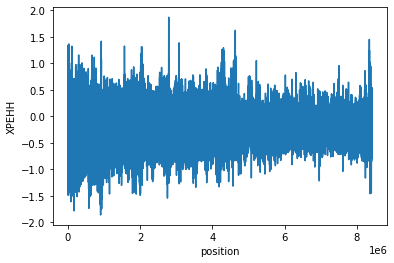

In [111]:
plt.plot(sel_df["xpehh"])
plt.xlabel("position")
plt.ylabel("XPEHH")
plt.savefig("xpehh.png")
plt.show()

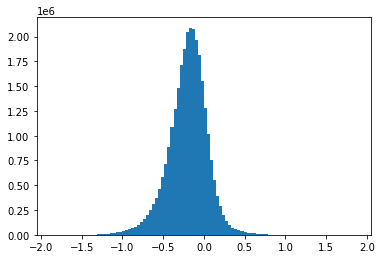

In [115]:
plt.hist(sel_df["xpehh"], bins=100)
plt.show()

In [112]:
sel_df
sel_df.sort_values(by='xpehh', ascending=False)

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh
2793910,NC_067199.1,28684878,NC_067199.1:28684878,28684900.0,0.006098,1981.820,0.279661,26.9185,1.86701
2793908,NC_067199.1,28684869,NC_067199.1:28684869,28684900.0,0.006098,1975.530,0.228814,28.5088,1.84071
2793896,NC_067199.1,28684816,NC_067199.1:28684816,28684800.0,0.006098,2870.630,0.440678,51.7572,1.74401
2793893,NC_067199.1,28684798,NC_067199.1:28684798,28684800.0,0.000000,2869.950,0.169492,52.4795,1.73788
2793911,NC_067199.1,28684880,NC_067199.1:28684880,28684900.0,0.000000,1983.090,0.084746,38.5301,1.71154
...,...,...,...,...,...,...,...,...,...
908581,NC_067200.1,9659379,NC_067200.1:9659379,9659380.0,0.018293,217.570,0.000000,14791.5000,-1.83241
908579,NC_067200.1,9659361,NC_067200.1:9659361,9659360.0,0.121951,209.224,0.000000,14791.5000,-1.84940
908582,NC_067200.1,9659381,NC_067200.1:9659381,9659380.0,0.920732,205.420,0.991525,14767.1000,-1.85665
908578,NC_067200.1,9659355,NC_067200.1:9659355,9659360.0,0.707317,203.280,0.000000,14791.5000,-1.86192


In [116]:
sel_df.sort_values(by=['chr', "pos"])
sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485
...,...,...,...,...,...,...,...,...,...
2117383,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044
2117384,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189
2117385,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337
2117386,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467


In [133]:
# Calculate the genomic position for each data point
chrom_lengths = sel_df.groupby("chr")["pos"].max() - sel_df.groupby("chr")["pos"].min()
chrom_offsets = chrom_lengths.cumsum().shift(1).fillna(0)
sel_df["genomic_position"] = sel_df["chr"].map(chrom_offsets).astype(int) + sel_df["pos"]
sel_df=sel_df.sort_values("genomic_position").reset_index(drop=True)
sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,z_scores,p_value,p_value_bonferroni,fdr,genomic_position
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172,1.585587,0.112833,1.0,0.999998,147067
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980,2.420221,0.015511,1.0,0.562653,147068
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395,2.266630,0.023413,1.0,0.679073,147069
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510,2.267113,0.023383,1.0,0.678719,147070
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485,2.267008,0.023390,1.0,0.678806,147072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28585158,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.538870,0.123836,1.0,0.999998,302664128
28585159,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.531082,0.125749,1.0,0.999998,302664135
28585160,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.586280,0.112676,1.0,0.999998,302664145
28585161,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.695978,0.089890,1.0,0.999998,302664175


In [ ]:
sel_df.to_csv("sel_df.csv", sep=",", header=True, index=False)

In [134]:
z_scores = stats.zscore(sel_df["xpehh"])
sel_df["z_scores"] = z_scores

In [135]:
p_values = stats.norm.sf(np.abs(sel_df["z_scores"])) * 2  # Two-tailed p-values
sel_df["p_value"] = p_values

sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,z_scores,p_value,p_value_bonferroni,fdr,genomic_position
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172,1.585587,0.112833,1.0,0.999998,147067
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980,2.420221,0.015511,1.0,0.562653,147068
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395,2.266630,0.023413,1.0,0.679073,147069
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510,2.267113,0.023383,1.0,0.678719,147070
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485,2.267008,0.023390,1.0,0.678806,147072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28585158,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.538870,0.123836,1.0,0.999998,302664128
28585159,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.531082,0.125749,1.0,0.999998,302664135
28585160,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.586280,0.112676,1.0,0.999998,302664145
28585161,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.695978,0.089890,1.0,0.999998,302664175


In [ ]:
sel_df.to_csv("sel_df.csv", sep=",", header=True, index=False)

In [136]:
# Bonferroni correction
_, p_values_bonferroni, _, _ = smm.multipletests(sel_df["p_value"], method='bonferroni')
sel_df["p_value_bonferroni"] = p_values_bonferroni

# Benjamini-Hochberg correction (False Discovery Rate)
_, fdr, _, _ = smm.multipletests(sel_df["p_value"], method='fdr_bh')
sel_df["fdr"] = fdr


alpha = 0.05
sig_bonf = sel_df[sel_df["p_value_bonferroni"] < alpha]
sig_fdr = sel_df[sel_df["fdr"] < alpha]

In [138]:
sig_fdr

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,z_scores,p_value,p_value_bonferroni,fdr,genomic_position
366,NC_067196.1,199640,NC_067196.1:199640,199640.0,0.256098,946.246,0.000000,11896.5000,-1.099410,-3.786341,0.000153,1.0,0.048536,199640
369,NC_067196.1,199679,NC_067196.1:199679,199679.0,0.329268,898.583,0.000000,11896.5000,-1.121860,-3.880590,0.000104,1.0,0.039616,199679
370,NC_067196.1,199682,NC_067196.1:199682,199682.0,0.000000,940.080,0.000000,11896.5000,-1.102250,-3.798264,0.000146,1.0,0.047305,199682
371,NC_067196.1,199683,NC_067196.1:199683,199683.0,0.000000,940.080,0.000000,11896.5000,-1.102250,-3.798264,0.000146,1.0,0.047305,199683
372,NC_067196.1,199684,NC_067196.1:199684,199684.0,0.231707,851.456,0.000000,11896.5000,-1.145260,-3.978828,0.000069,1.0,0.031905,199684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28541127,NC_067202.1,19050881,NC_067202.1:19050881,19050900.0,0.000000,679.826,0.000000,124.5300,0.737124,3.923777,0.000087,1.0,0.036085,302237286
28541128,NC_067202.1,19050884,NC_067202.1:19050884,19050900.0,0.335366,673.717,0.262712,118.5840,0.754452,3.996523,0.000064,1.0,0.030563,302237289
28541129,NC_067202.1,19050886,NC_067202.1:19050886,19050900.0,0.000000,674.424,0.000000,119.8970,0.750126,3.978362,0.000069,1.0,0.031942,302237291
28541130,NC_067202.1,19050887,NC_067202.1:19050887,19050900.0,0.335366,673.717,0.254237,118.8870,0.753345,3.991876,0.000066,1.0,0.030924,302237292


In [141]:
invad_loc = chrom_offsets["NC_067199.1"] + (28467137+28495140)/2
invad_loc

217279315.5

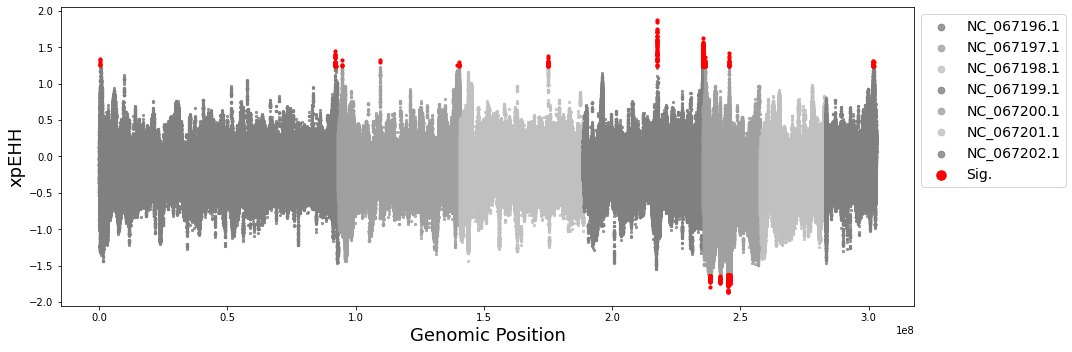

In [148]:
# Create the Manhattan plot figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']

# Create the colormap
custom_cmap = ListedColormap(shades_of_grey)

#plot position of the invadolysin locus
#plt.axvline(x=invad_loc, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(sel_df.groupby("chr")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["genomic_position"], group["xpehh"], s=5, alpha=0.8, color=color, label=f'{chrom}')

# Plot the significant data points (Bonferroni corrected) in red
ax.scatter(sig_bonf["genomic_position"], sig_bonf["xpehh"], s=10, alpha=1, color='red', label='Sig.')

# Set the x-axis and y-axis labels
ax.set_xlabel("Genomic Position", fontsize=18)
ax.set_ylabel("xpEHH", fontsize=18)

# Add the legend outside the plot in the upper right corner
ax.legend(markerscale=3, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to fit the plot in the figure
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot as an SVG file
#fig.savefig('nw_vs_se_xpehh.svg', format='svg')

# Save the plot as a 300 dpi PNG file
fig.savefig('nw_vs_se_xpehh.png', dpi=300, format='png')


In [145]:
invad_start = chrom_offsets["NC_067199.1"] + 28467137
invad_stop  = chrom_offsets["NC_067199.1"] + 28495140

In [151]:
sel_df.loc[ (sel_df["chr"] == "NC_067199.1") &
            (sel_df["pos"] > 28467137) &
            (sel_df["pos"] < 28495140) ]

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,z_scores,p_value,p_value_bonferroni,fdr,genomic_position
19906629,NC_067199.1,28467142,NC_067199.1:28467142,28467100.0,0.024390,2589.41,1.000000,1087.53,0.376759,2.410897,0.015913,1.0,0.569483,217265319
19906630,NC_067199.1,28467150,NC_067199.1:28467150,28467200.0,0.000000,2610.49,0.000000,1087.53,0.380281,2.425683,0.015280,1.0,0.558523,217265327
19906631,NC_067199.1,28467151,NC_067199.1:28467151,28467200.0,0.000000,2610.49,0.000000,1087.53,0.380281,2.425683,0.015280,1.0,0.558523,217265328
19906632,NC_067199.1,28467178,NC_067199.1:28467178,28467200.0,0.006098,2583.66,0.000000,1087.53,0.375794,2.406845,0.016091,1.0,0.572359,217265355
19906633,NC_067199.1,28467183,NC_067199.1:28467183,28467200.0,0.000000,2641.10,0.000000,1089.20,0.384678,2.444142,0.014520,1.0,0.544429,217265360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19909081,NC_067199.1,28495079,NC_067199.1:28495079,28495100.0,0.000000,3188.62,0.000000,1440.31,0.345148,2.278188,0.022715,1.0,0.670296,217293256
19909082,NC_067199.1,28495081,NC_067199.1:28495081,28495100.0,0.000000,3188.62,0.000000,1440.31,0.345148,2.278188,0.022715,1.0,0.670296,217293258
19909083,NC_067199.1,28495107,NC_067199.1:28495107,28495100.0,0.012195,3187.48,0.932203,1348.21,0.373688,2.398004,0.016485,1.0,0.578817,217293284
19909084,NC_067199.1,28495108,NC_067199.1:28495108,28495100.0,0.000000,3187.58,0.000000,1348.69,0.373548,2.397416,0.016511,1.0,0.579258,217293285


In [163]:
sel_df.loc[ (sel_df["chr"] == "NC_067199.1") ].sort_values("xpehh", ascending=False).head(99)["pos"].min()

28684454

In [165]:
pos=list(sel_df.loc[ (sel_df["chr"] == "NC_067199.1") ].sort_values("xpehh", ascending=False).head(99)["pos"])

In [168]:
28495140-28684454

-189314

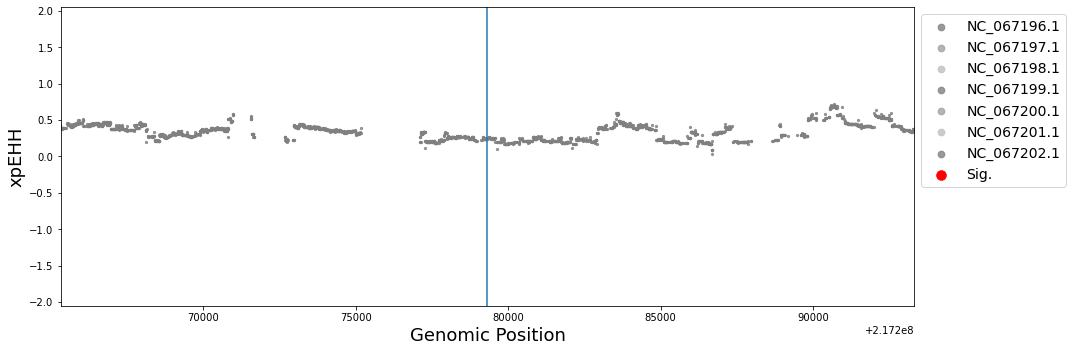

In [146]:
# Create the Manhattan plot figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']

# Create the colormap
custom_cmap = ListedColormap(shades_of_grey)

#plot position of the invadolysin locus
plt.axvline(x=invad_loc, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(sel_df.groupby("chr")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["genomic_position"], group["xpehh"], s=5, alpha=0.8, color=color, label=f'{chrom}')

# Plot the significant data points (Bonferroni corrected) in red
ax.scatter(sig_bonf["genomic_position"], sig_bonf["xpehh"], s=10, alpha=1, color='red', label='Sig.')

# Set the x-axis and y-axis labels
ax.set_xlabel("Genomic Position", fontsize=18)
ax.set_ylabel("xpEHH", fontsize=18)

# Add the legend outside the plot in the upper right corner
ax.legend(markerscale=3, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

#focus in on invadolysin locus
plt.xlim([invad_start, invad_stop])

# Adjust the layout to fit the plot in the figure
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot as an SVG file
#fig.savefig('invadolysin_locus_nw_vs_se_xpehh.svg', format='svg')

# Save the plot as a 300 dpi PNG file
fig.savefig('invadolysin_locus_nw_vs_se_xpehh.png', dpi=300, format='png')


## Compare XPEHH values to the percent of Sb introgression in NW Africa

read in the introgression data from the `09-ancestry.ipynb` notebook

In [234]:
i_df = pd.read_csv(f"{proj_dir}/results/rfmix/rfmix_perc_bovis_genome.csv", sep=",")
i_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,n_sb,n_sh_nw,n_sh_se,perc_sb,perc_sh_nw,perc_sh_se
0,NC_067195.1,14416,75442,0.05,0.26,582,0,156,42,1.0,0.048780,0.0
1,NC_067195.1,75442,106309,0.26,0.37,335,0,155,42,1.0,0.054878,0.0
2,NC_067195.1,106309,146168,0.37,0.51,465,0,154,42,1.0,0.060976,0.0
3,NC_067195.1,146168,156662,0.51,0.55,580,0,154,42,1.0,0.060976,0.0
4,NC_067195.1,156662,164518,0.55,0.57,885,0,155,42,1.0,0.054878,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067202.1,19335566,19381118,67.37,67.53,4950,0,159,42,1.0,0.030488,0.0
39473,NC_067202.1,19381118,19401743,67.53,67.60,2335,0,158,42,1.0,0.036585,0.0
39474,NC_067202.1,19401743,19427939,67.60,67.69,2290,0,159,42,1.0,0.030488,0.0
39475,NC_067202.1,19427939,19464116,67.69,67.82,1825,0,160,42,1.0,0.024390,0.0


In [235]:
sel_df=pd.read_csv("sel_df.csv", sep=",")

add the introgression data to an interval tree

In [236]:
trees={}

# Iterate over the DataFrame rows
for index, row in tqdm(i_df.iterrows()):
    # Get the chromosome name
    chrom      = row["chrom"]
    start      = row["s_pos"]
    stop       = row["e_pos"]
    perc_intro = row["perc_sh_nw"]
    
    # Initialize the interval tree for this chromosome if it doesn't exist yet
    if chrom not in trees:
        trees[chrom] = IntervalTree()
    
    # Add the interval to the tree
    trees[chrom][start:stop] = perc_intro

39477it [00:09, 3973.12it/s] 


now cycle through the table containing the xpehh data, look up that position in the interval tree and add it to the dataframe

In [237]:
sel_df["nw_intro"] = None
sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,z_scores,p_value,p_value_bonferroni,fdr,genomic_position,nw_intro
0,NC_067196.1,147067,NC_067196.1:147067,147067.0,0.158537,3849.020,0.381356,2542.010,0.180172,1.585587,0.112833,1.0,0.999998,147067,None
1,NC_067196.1,147068,NC_067196.1:147068,147068.0,0.048780,3270.680,0.186441,1366.650,0.378980,2.420221,0.015511,1.0,0.562653,147068,None
2,NC_067196.1,147069,NC_067196.1:147069,147069.0,0.024390,3022.890,0.000000,1374.130,0.342395,2.266630,0.023413,1.0,0.679073,147069,None
3,NC_067196.1,147070,NC_067196.1:147070,147070.0,0.000000,3023.680,0.000000,1374.130,0.342510,2.267113,0.023383,1.0,0.678719,147070,None
4,NC_067196.1,147072,NC_067196.1:147072,147072.0,0.018293,3023.510,0.000000,1374.130,0.342485,2.267008,0.023390,1.0,0.678806,147072,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28585158,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.538870,0.123836,1.0,0.999998,302664128,None
28585159,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.531082,0.125749,1.0,0.999998,302664135,None
28585160,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.586280,0.112676,1.0,0.999998,302664145,None
28585161,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.695978,0.089890,1.0,0.999998,302664175,None


In [238]:
for index,row in tqdm(sel_df.iterrows()):
    chrom=row["chr"]
    pos=row["pos"]
    intro=list(trees[chrom][pos])[0].data
    sel_df.loc[index, "nw_intro"] = intro

28585163it [48:20, 9854.86it/s] 


In [239]:
sel_df.to_csv("sel_df.csv", sep=",", header=True, index=False)

In [240]:
sel_df["nw_intro"].min()

0.0

plot the results as a scatter plot

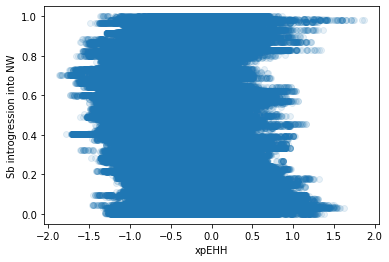

<Figure size 432x288 with 0 Axes>

In [241]:
plt.scatter(sel_df["xpehh"], sel_df["nw_intro"], alpha=0.1)
plt.xlabel("xpEHH")
plt.ylabel("Sb introgression into NW")
plt.show()

# Save the plot as an SVG file
plt.savefig('introgression_vs_xpehh.svg', format='svg')

# Save the plot as a 300 dpi PNG file
plt.savefig('introgression_vs_xpehh.png', dpi=300, format='png')